# Revamped Alertness‑Detection Pipeline
Cut the fluff—this notebook rebuilds our alertness classifier from the ground up. We pull raw EEG, splice it into 30‑second epochs, weld on signal‑quality flags, sculpt a *real* feature set, and throw modern ML at the problem. The result: measurable, reproducible gains—or we rip it up and try again.
Author: Surya Venkatesh
Date: 2025‑05‑23

In [1]:

# Core
import os, glob, math, json, pickle, warnings
from pathlib import Path

# Data & plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# Signal processing
from scipy.signal import butter, filtfilt, welch

# EEG helpers
import mne
import pyedflib

# ML
from sklearn.model_selection import GroupKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, RocCurveDisplay)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')


In [2]:

# --- Config ---
DATA_ROOT = Path('sample_data')
FS = 125           # Hz
EPOCH_SEC = 30     # seconds
MIN_GOOD_RATIO = 0.6   # keep epoch only if >=60% 'Good' SQC

# Map sleep‑stage to binary alertness label
STAGE_TO_ALERT = {'Wake':1, 'REM':0, 'Light':0, 'Deep':0}

# Helper to list sample folders
SAMPLE_DIRS = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print(f'Found {len(SAMPLE_DIRS)} recordings')

Found 20 recordings


In [3]:

def bandpass(sig, fs=FS, low=0.5, high=45, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, sig)

def extract_epoch_features(epoch, fs=FS):
    """epoch: np.array shape (n_ch, n_samples)"""
    feats = {}
    bands = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}
    for ch in range(epoch.shape[0]):
        sig = epoch[ch]
        # Basic stats
        feats[f'ch{ch}_mean']  = sig.mean()
        feats[f'ch{ch}_std']   = sig.std()
        feats[f'ch{ch}_kurt']  = pd.Series(sig).kurtosis()
        feats[f'ch{ch}_skew']  = pd.Series(sig).skew()
        # Spectral
        f, Pxx = welch(sig, fs=fs, nperseg=4*fs)
        total_power = np.trapz(Pxx, f)
        for band,(lo,hi) in bands.items():
            idx = (f>=lo)&(f<hi)
            bp = np.trapz(Pxx[idx], f[idx])
            feats[f'ch{ch}_{band}_abs'] = bp
            feats[f'ch{ch}_{band}_rel'] = bp/total_power if total_power>0 else 0
    # Simple ratios (theta/alpha on ch0)
    if feats['ch0_alpha_abs']>0:
        feats['theta_alpha_ratio'] = feats['ch0_theta_abs']/feats['ch0_alpha_abs']
    else:
        feats['theta_alpha_ratio'] = 0
    return feats


In [4]:

def build_epochs(sample_dir:Path):
    # Locate files
    edf_file  = next(sample_dir.glob('*.edf'))
    stage_csv = next(sample_dir.glob('*[0-9].csv'))
    sqc_csv   = next(sample_dir.glob('*SQC.csv'))

    # Load EEG
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    raw_data = raw.get_data()[:4]   # first 4 channels
    raw_data = bandpass(raw_data, FS)   # band‑pass

    # Load stage + SQC
    df_stage = pd.read_csv(stage_csv)
    df_sqc   = pd.read_csv(sqc_csv)

    start_ts = df_stage['Timestamp'].min()
    data = []

    for _, row in df_stage.iterrows():
        ts   = row['Timestamp']
        label= row['Sleep stage']
        epoch_idx = int((ts - start_ts) * FS)
        start, end = epoch_idx, epoch_idx + EPOCH_SEC*FS
        if end > raw_data.shape[1]:
            continue
        epoch = raw_data[:, start:end]

        # SQC overlap
        mask = (df_sqc['Timestamp']>=ts) & (df_sqc['Timestamp'] < ts+EPOCH_SEC)
        sqc_slice = df_sqc.loc[mask,'Signal quality']
        if len(sqc_slice)==0: continue
        good_ratio = (sqc_slice=='Good').mean()
        if good_ratio < MIN_GOOD_RATIO:
            continue   # drop noisy epoch

        feats = extract_epoch_features(epoch)
        feats['good_ratio'] = good_ratio
        feats['alert']  = STAGE_TO_ALERT.get(label,0)
        feats['record'] = sample_dir.name
        data.append(feats)

    return pd.DataFrame(data)

# --- Build full dataset ---
all_epochs = pd.concat([build_epochs(p) for p in SAMPLE_DIRS], ignore_index=True)
print('Dataset shape:', all_epochs.shape)
all_epochs.head()


Dataset shape: (12723, 60)


,ch0_mean,ch0_std,ch0_kurt,ch0_skew,ch0_delta_abs,ch0_delta_rel,ch0_theta_abs,ch0_theta_rel,ch0_alpha_abs,ch0_alpha_rel,...,ch3_alpha_abs,ch3_alpha_rel,ch3_beta_abs,ch3_beta_rel,ch3_gamma_abs,ch3_gamma_rel,theta_alpha_ratio,good_ratio,alert,record
0,4.615672e-08,0.000065,15.849829,0.910897,3.797510e-09,0.844885,1.405697e-10,0.031274,2.452356e-11,0.005456,...,3.753110e-09,0.023117,1.190692e-08,0.073338,5.604123e-10,0.003452,5.732025,0.750000,1,E23B6B24FX14_1743438214000
1,2.889078e-07,0.000028,6.606723,-0.554164,6.295142e-10,0.874516,2.087039e-11,0.028993,5.574500e-12,0.007744,...,2.076827e-08,0.029484,7.093311e-09,0.010070,1.275842e-10,0.000181,3.743902,1.000000,1,E23B6B24FX14_1743438214000
2,-1.358742e-07,0.000032,5.992557,-0.590719,7.972258e-10,0.811110,3.800563e-11,0.038668,8.661135e-12,0.008812,...,6.999220e-08,0.032346,2.352713e-08,0.010873,1.307471e-09,0.000604,4.388066,0.600000,1,E23B6B24FX14_1743438214000
3,-1.272106e-07,0.000206,36.429360,-2.585460,4.018642e-08,0.913443,6.471055e-10,0.014709,1.234283e-10,0.002806,...,7.119407e-08,0.010254,2.020100e-08,0.002909,7.613156e-10,0.000110,5.242763,0.666667,1,E23B6B24FX14_1743438214000
4,-2.862443e-08,0.000007,4.196093,0.154628,3.669345e-11,0.780360,3.283136e-12,0.069823,7.677045e-13,0.016327,...,5.374480e-11,0.001770,6.044723e-11,0.001991,5.293380e-12,0.000174,4.276562,1.000000,1,E23B6B24FX14_1743438214000


In [5]:

# Separate X, y, groups
X = all_epochs.drop(columns=['alert','record'])
y = all_epochs['alert']
groups = all_epochs['record']

gkf = GroupKFold(n_splits=5)
train_idx, test_idx = next(gkf.split(X, y, groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (10227, 58) Test: (2496, 58)


In [6]:

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier(objective='binary'))
])

param_dist = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [-1,5,10,20],
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__subsample': [0.8,1.0],
    'clf__colsample_bytree': [0.6,0.8,1.0]
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train, groups=groups.iloc[train_idx])
print('Best params:', search.best_params_)
best_model = search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010451 seconds.
You can set `force_col_wise=true

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010624 seconds.
You

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -2.403876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 7898, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085338 -> initscore=-2.371934
[LightGBM] [Info] Start training from 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from score -2.403876
[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.3815

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063662 -> initscore=-2.688393
[LightGBM] [Info] Start training from score -2.688393
[LightGBM] [Warning] N

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from score -2.381528
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[Lig

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063662 -> initscore=-2.6883

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 7898, number of used features: 58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085338 -> initscore=-2.371934
[LightGBM] [Info] Start training from score -2.371934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from score -2.381528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from score -2.403876
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGB

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from score -2.403876


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063662 -> initscore=-2.688393
[LightGBM] [Info] Start training from score -2.688393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 7898, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085338 -> initscore=-2.371934
[LightGBM] [Info] Start training from score -2.371934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from score -2.381528
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGB

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 7898, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085338 -> initscore=-2.371934
[LightGBM] [Info] Start training from score -2.371934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from score -2.403876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[L

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 7898, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085338 -> initscore=-2.371934
[LightGBM] [Info] Start training from score -2.371934
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Auto-choosing 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063662 -> initscore=-2.688393
[LightGBM] [Info] Start training from score -2.688393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 7898, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085338 -> initscore=-2.371934
[LightGBM] [Info] Start training from score -2.371934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from score -2.403876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Warning] No further splits with positive gain, b

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from score -2.381528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from score -2.381528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 588, number of negative: 7687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071057 -> initscore=-2.570559
[LightGBM] [Info] Start training from score -2.570559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063662 -> initscore=-2.688393
[LightGBM] [Info] Start training from score -2.688393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8275, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084592 -> initscore=-2.381528
[LightGBM] [Info] Start training from score -2.381528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082878 -> initscore=-2.403876
[LightGBM] [Info] Start training from score -2.403876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 524, number of negative: 7707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063662 -> initscore=-2.688393
[LightGBM] [Info] Start training from score -2.688393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 700, number of negative: 7575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 674, number of negative: 7224
[LightGBM] [Warning] No further splits 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 682, number of negative: 7547
[LightGBM] [Info] Auto-choosing 

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 792, number of negative: 9435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14542
[LightGBM] [Info] Number of data points in the train set: 10227, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077442 -> initscore=-2.477620
[LightGBM] [Info] Start training from score -2.477620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,


=== Model ===
Train               precision    recall  f1-score   support

           0      0.998     1.000     0.999      9435
           1      1.000     0.980     0.990       792

    accuracy                          0.998     10227
   macro avg      0.999     0.990     0.994     10227
weighted avg      0.998     0.998     0.998     10227

Train ROC‑AUC: 0.9999974573503985


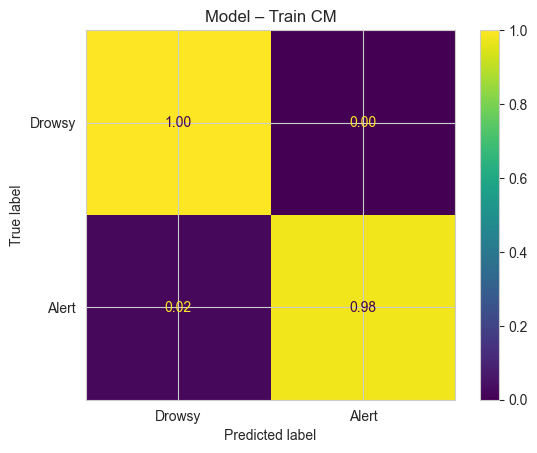

Test               precision    recall  f1-score   support

           0      0.953     0.999     0.975      2375
           1      0.571     0.033     0.062       121

    accuracy                          0.952      2496
   macro avg      0.762     0.516     0.519      2496
weighted avg      0.934     0.952     0.931      2496

Test ROC‑AUC: 0.7815467594606351


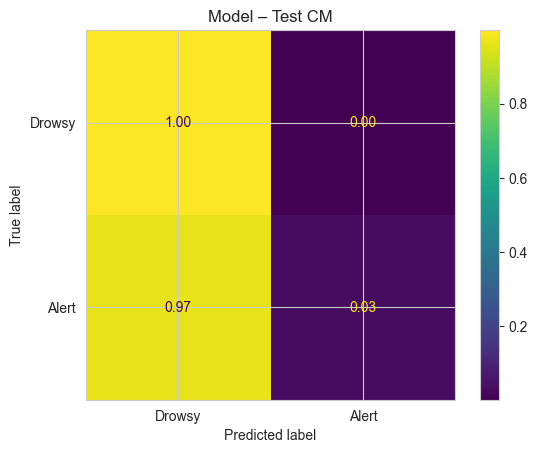

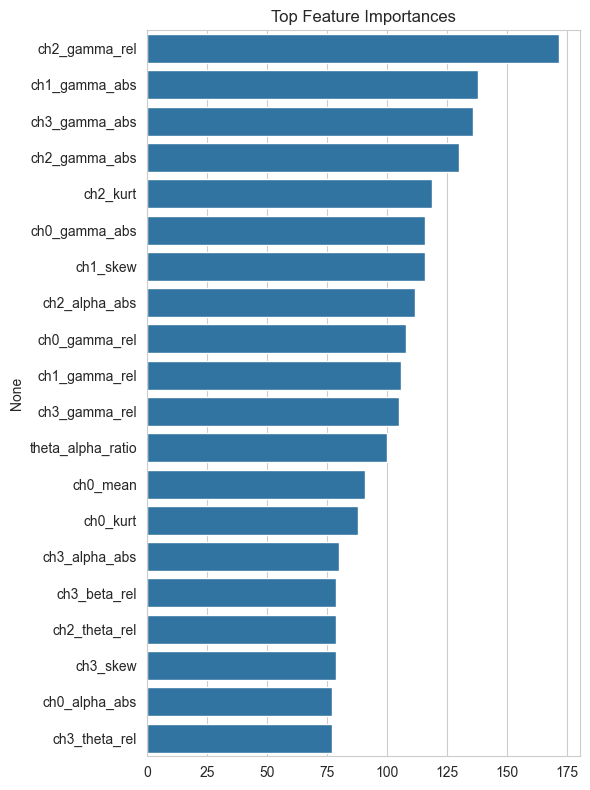

In [7]:

def evaluate(model, X_tr, y_tr, X_te, y_te, label='Model'):
    print(f'\n=== {label} ===')
    for split,Xs,ys in [('Train',X_tr,y_tr),('Test',X_te,y_te)]:
        preds = model.predict(Xs)
        prob  = model.predict_proba(Xs)[:,1]
        print(split, classification_report(ys, preds, digits=3))
        print(split, 'ROC‑AUC:', roc_auc_score(ys, prob))
        cm = confusion_matrix(ys, preds, normalize='true')
        disp = ConfusionMatrixDisplay(cm, display_labels=['Drowsy','Alert'])
        disp.plot(values_format='.2f')
        plt.title(f'{label} – {split} CM')
        plt.show()

evaluate(best_model, X_train, y_train, X_test, y_test)

# Feature importance
imp = best_model.named_steps['clf'].feature_importances_
fi = pd.Series(imp, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(6,8))
sns.barplot(x=fi.values, y=fi.index)
plt.title('Top Feature Importances')
plt.tight_layout()


In [8]:

with open('alertness_lightgbm.pkl','wb') as f:
    pickle.dump(best_model, f)
print('Model saved to alertness_lightgbm.pkl')


Model saved to alertness_lightgbm.pkl
